#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [3]:
def entropy_func(class_count, num_samples):
    f = class_count / num_samples
    return f * np.log(f)

class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return self.group_classes.size

    def group_entropy(self):
        counter = Counter(self.group_classes)
        group_entropy = 0

        for class_index in counter.keys():
            group_entropy += entropy_func(counter[class_index], self.group_classes.size)
        return -1 * group_entropy


class Node:
    def __init__(self, split_feature, split_val, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.val is None:
            if data[self.split_feature] >= self.split_val:
                return self.child_node_a.predict(data)
            else:
                return self.child_node_b.predict(data)
        else:
            return self.val


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        a_entropy = group_a.entropy
        b_entropy = group_b.entropy
        a_weight = len(group_a)
        b_weight = len(group_b)
        return np.average([a_entropy, b_entropy], weights=[a_weight, b_weight])  # weighted average # check if it's correct!

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        return parent_group.entropy - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values, classes):
        max_information_gain = 0
        best_feature_split = None
        for unique_feature_value in list(set(feature_values)):
            child_group_a_indexes = [index for index, value in enumerate(feature_values) if value >= unique_feature_value]
            child_group_b_indexes = [index for index, value in enumerate(feature_values) if value < unique_feature_value]
            child_group_a = Group(np.array([classes[i] for i in child_group_a_indexes]))
            child_group_b = Group(np.array([classes[i] for i in child_group_b_indexes]))
            information_gain = self.get_information_gain(Group(classes), child_group_a, child_group_b)
            if max_information_gain < information_gain:
                max_information_gain = information_gain
                best_feature_split = unique_feature_value
        return max_information_gain, best_feature_split

    def get_best_split(self, data, classes):
        best_split = None  # index of best feature to split
        best_feature_split = None  # index of best feature point to split
        max_information_gain = 0
        for feature_index in range(data[0].size):
            information_gain, feature_split = self.get_best_feature_split(data[:, feature_index], classes)
            if max_information_gain < information_gain:
                max_information_gain = information_gain
                best_feature_split = feature_split
                best_split = feature_index
        return best_split, best_feature_split

    def build_tree(self, data, classes, depth=0):
        if len(set(classes)) == 1:
            return Node(None, None, depth=depth, val=classes[0])

        if depth == self.max_depth:
            return Node(None, None, depth=depth, val=max(Counter(classes)))

        best_split, best_feature_split = self.get_best_split(data, classes)

        child_a_indexes = [index for index, value in enumerate(data[:, best_split]) if value >= best_feature_split]
        child_b_indexes = [index for index, value in enumerate(data[:, best_split]) if value < best_feature_split]
        data_a_child = np.array([data[i, :] for i in child_a_indexes])
        data_b_child = np.array([data[i, :] for i in child_b_indexes])

        classes_a_child= np.array([classes[i] for i in child_a_indexes])
        classes_b_child= np.array([classes[i] for i in child_b_indexes])

        self.tree = Node(split_feature = best_split,
                    split_val= best_feature_split,
                    depth=depth,
                    child_node_a=self.build_tree(data_a_child, classes_a_child, depth+1),
                    child_node_b=self.build_tree(data_b_child, classes_b_child, depth+1))

        return self.tree

    def predict(self, data):
        return self.tree.predict(data)

In [4]:
def test_of_DecisionTreeClassifier(depth=3, printable=False):
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    correct_number = 0
    incorrect_number = 0
    for sample, gt in zip(x_test, y_test):
        prediction = dc.predict(sample)
        if prediction == gt:
            correct_number+=1
        else:
            incorrect_number+=1
        if printable:
            print(f"Prediction -> {prediction},  Real -> {gt}")
    accuracy = correct_number/(correct_number+incorrect_number)
    return(accuracy)

def test_of_DecisionTreeClassifier_trained_data(depth=3, printable=False):
    dc = DecisionTreeClassifier(depth)
    dc.build_tree(x_train, y_train)
    correct_number = 0
    incorrect_number = 0
    for sample, gt in zip(x_train, y_train):
        prediction = dc.predict(sample)
        if prediction == gt:
            correct_number+=1
        else:
            incorrect_number+=1
        if printable:
            print(f"Prediction -> {prediction},  Real -> {gt}")
    accuracy = correct_number/(correct_number+incorrect_number)
    return(accuracy)

In [5]:
# zadany test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
print("Acuracy: ",test_of_DecisionTreeClassifier(printable=True))

Prediction -> 2,  Real -> 1
Prediction -> 2,  Real -> 2
Prediction -> 2,  Real -> 2
Prediction -> 1,  Real -> 1
Prediction -> 0,  Real -> 0
Prediction -> 2,  Real -> 2
Prediction -> 1,  Real -> 1
Prediction -> 0,  Real -> 0
Prediction -> 0,  Real -> 0
Prediction -> 1,  Real -> 1
Prediction -> 2,  Real -> 2
Prediction -> 0,  Real -> 0
Prediction -> 1,  Real -> 1
Prediction -> 2,  Real -> 2
Prediction -> 2,  Real -> 2
Acuracy:  0.9333333333333333


In [10]:
for _ in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    print(f"Acuracy: ",test_of_DecisionTreeClassifier())

Acuracy:  0.6666666666666666
Acuracy:  0.8
Acuracy:  0.8666666666666667
Acuracy:  0.4
Acuracy:  0.6666666666666666
Acuracy:  0.5333333333333333
Acuracy:  0.8666666666666667
Acuracy:  0.5333333333333333
Acuracy:  0.7333333333333333
Acuracy:  0.4666666666666667


Average (100 tests):  0.7526666666666659
best_accuracy:  0.9333333333333333
worst_accuracy:  0.4


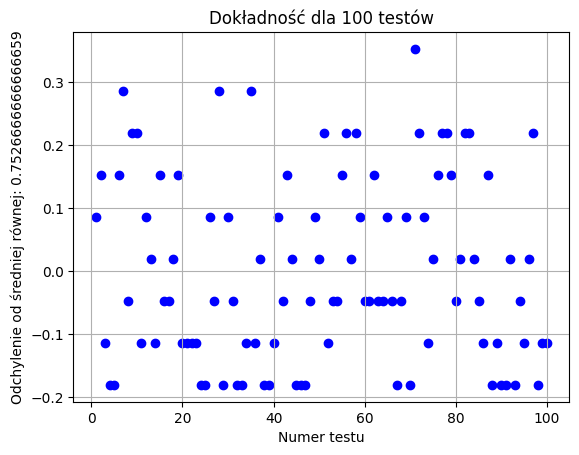

In [14]:
depth=3
test_size=0.1
print_plot=True

accuracies = []
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    accuracy = test_of_DecisionTreeClassifier(depth)
    accuracies.append(accuracy)

average = sum(accuracies)/100
difference_from_average  = [average - accuracies[i] for i in range(len(accuracies)) ]
if print_plot:
    print("Average (100 tests): ", average)
    print("best_accuracy: ", max(accuracies))
    print("worst_accuracy: ", min(accuracies))
    plt.scatter(range(1, 101), difference_from_average, color='blue', marker='o')
    plt.title('Dokładność dla 100 testów')
    plt.xlabel('Numer testu')
    plt.ylabel(f'Odchylenie od średniej równej: {average}')
    plt.grid(True)
    plt.show()

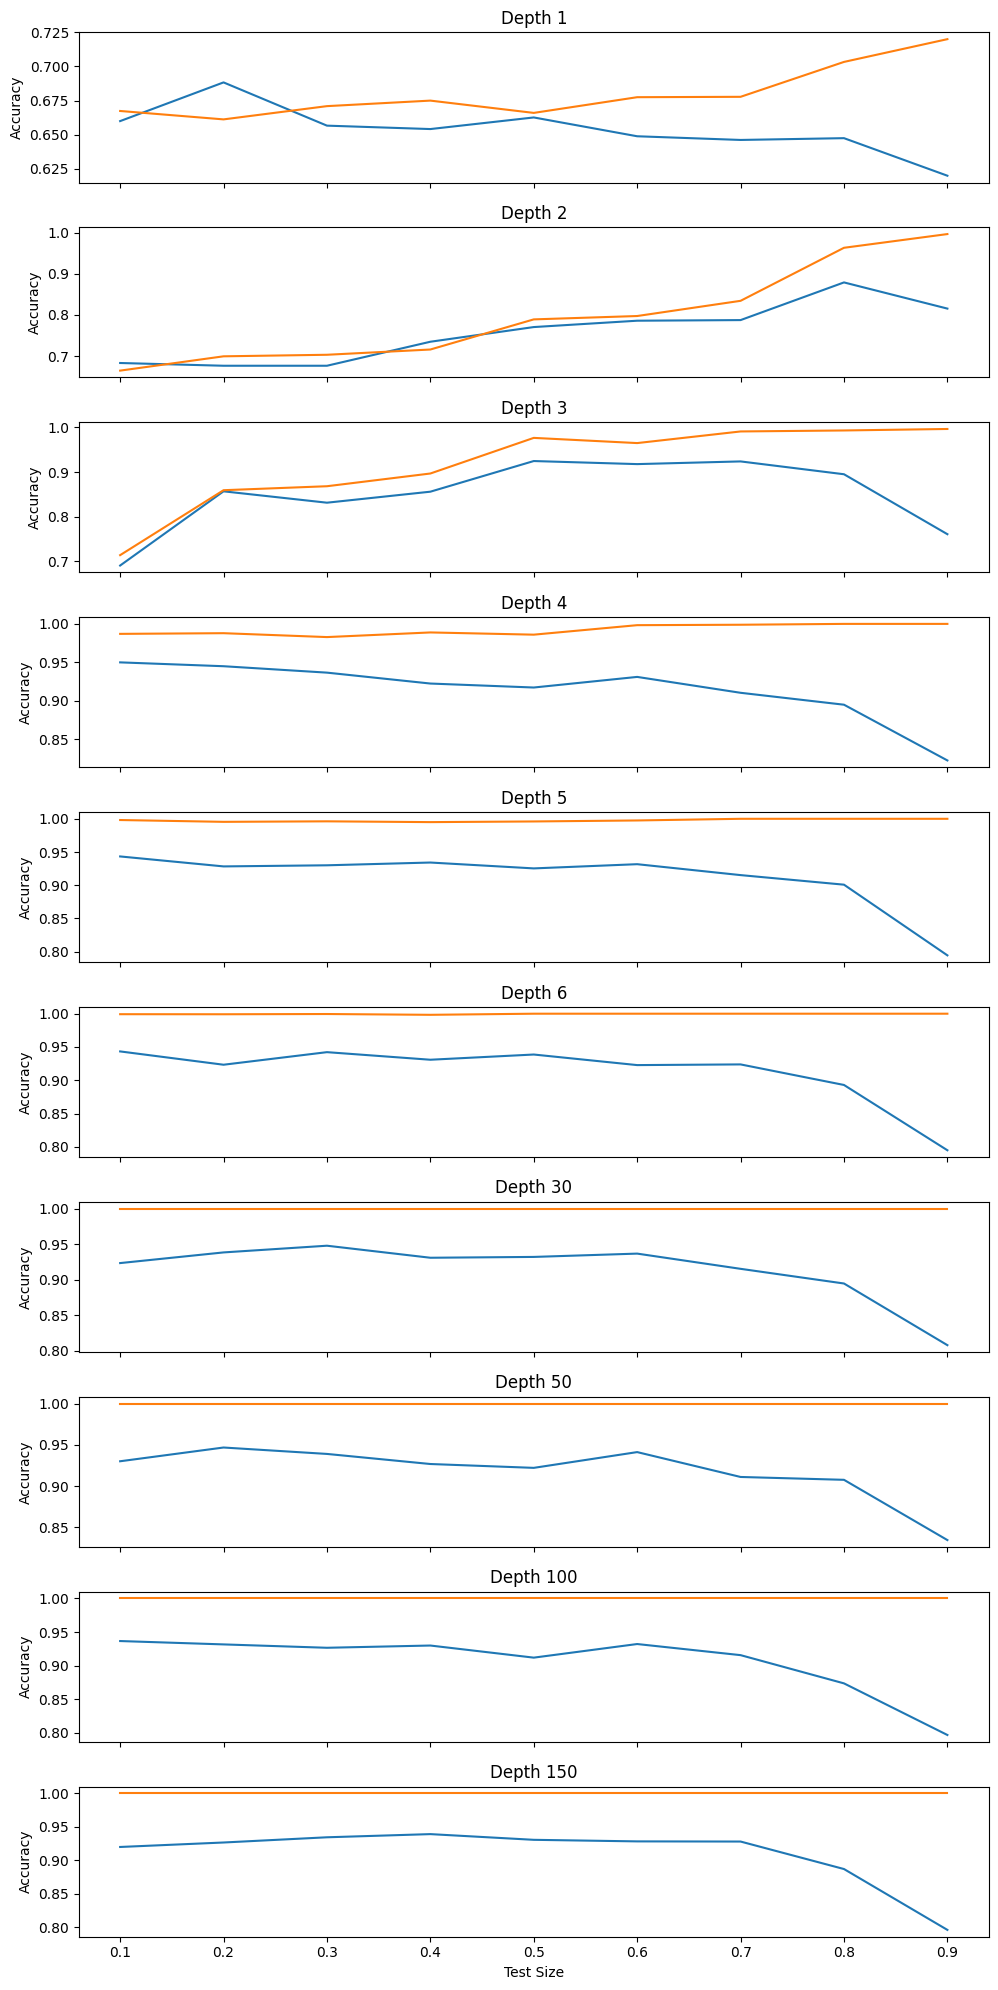

In [16]:
test_size_range = [i/10 for i in range(1, 10)]
depth_range =  list(range(1, 7)) + [30, 50, 100, 150]

fig, axs = plt.subplots(len(depth_range), figsize=(10, 20), sharex=True)
for i, depth_ in enumerate(depth_range):
    accuracies = []
    accuracies_trained = []
    for test_size_ in test_size_range:
        accuracy_list = []
        accuracy_list_trained = []
        for _ in range(20):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_)
            accuracy = test_of_DecisionTreeClassifier(depth_)
            accuracy_trained = test_of_DecisionTreeClassifier_trained_data(depth_)
            accuracy_list.append(accuracy)
            accuracy_list_trained.append(accuracy_trained)

        average_accuracy = np.mean(accuracy_list)
        accuracies.append(average_accuracy)
        average_accuracy_trained = np.mean(accuracy_list_trained)
        accuracies_trained.append(average_accuracy_trained)

    axs[i].plot(test_size_range, accuracies, label=f'Depth {depth_}')
    axs[i].plot(test_size_range, accuracies_trained, label=f'Depth {depth_}')

    axs[i].set_ylabel('Accuracy')
    axs[i].set_title(f'Depth {depth_}')

axs[-1].set_xlabel('Test Size')
plt.tight_layout()
plt.show()